## II - Algorithme de Co-Clustering : Bregman Block Average (BBAC)

Importons les packages nécessaires :

In [173]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import normalized_mutual_info_score

### 1) Prétraitement de la base de données 20 Newsgroup

#### Chargeons les données 

La documentation de Scikit-learn$^{[11]}$ détaille comment charger la base de données 20 Newsgroup. Celle-ci est une liste de plus de 18 000 posts de média, chacun associé à un label (parmi 20) spécifiant son thème. Chargeons les données et imprimons la dénomination des 20 catégories possibles :

In [174]:
news = datasets.fetch_20newsgroups()
print("\nListe des catégories / thèmes des posts : \n")
print(list(news.target_names))


Liste des catégories / thèmes des posts : 

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


#### Restriction à une sous base de données 

Nous souhaitons travailler avec moins de 18 000 posts et de 20 classes afin d'avoir des objets plus manipulables en termes de temps de calcul. Nous créons ainsi une sous base de données en choisissant de ne charger les données que pour deux catégories : "espace" et "religion chrétienne" (dans l'espoir que leur champs lexicaux soient éloignés). Nous profitons également de cette étape pour élimiter les en-têtes, les bas de page et les citations associés aux posts.

In [175]:
cats = ['sci.space','soc.religion.christian']
newsgroups_train = datasets.fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'),categories=cats)
list(newsgroups_train.target_names)

['sci.space', 'soc.religion.christian']

Après restriction de nos données à ces deux catégories, nous n'avons plus que **1192 posts et 2 classes** (codées par le label 0 ou 1). On constate également que nos données ne sont pas ordonnées par label (comme c'était le cas pour la base des iris).

In [176]:
print("Dimension du vecteur de labels : ", newsgroups_train.target.shape) # target contient les labels des posts 
print("Exemple des dix premiers labels :", newsgroups_train.target[:10])

Dimension du vecteur de labels :  (1192,)
Exemple des dix premiers labels : [1 0 0 1 0 1 1 0 1 0]


Par ailleurs, la commande ci-dessous montre qu'il y a 593 posts de label=0 ('space') et 599 posts de label=1 ('religion'). Notre échantillon est donc équitablement réparti entre nos deux catégories. 

In [177]:
print('Nombres de posts associés au label=0 :', sum(newsgroups_train.target==0))
print('Nombres de posts associés au label=1 :', sum(newsgroups_train.target==1))

Nombres de posts associés au label=0 : 593
Nombres de posts associés au label=1 : 599


Visualisons un post associé au label=0 ('space') :

In [109]:
print("Post de label : ",newsgroups_train.target[1])
print(newsgroups_train.data[1]) # data est une liste contenant les posts

Post de label :  0
You have missed something.  There is a big difference between being in
the SAME PLANE and in exactly the same state (positions and velocities
equal).  IN addition to this, there has always been redundancies proposed.

Bob
--


Visualisons un post associé au label=1 ('religion') :

In [110]:
print("Post de label : ",newsgroups_train.target[0])
print(newsgroups_train.data[0])

Post de label :  1
I think it was Lewis who said that in a wedding, it's the principals  
that marry each other; the church and the state are present merely as  
witnesses.

------------------------------------------------------------
Rob Steele                 In coming to understand anything 
MIT Lincoln Laboratory    we are rejecting the facts as they
244 Wood St., M-203       are for us in favour of the facts
Lexington, MA  02173      as they are.    
617/981-2575                              C.S. Lewis


On remarque que le fait d'avoir retiré les bas de page et les citations des données n'a pas permis de parfaitement nettoyer ces dernières puisque l'exemple ci-dessus contient toujours ce qui semble être une signature contenant une citation.

#### Conversion des données en une matrice de décompte des "tokens"

On transforme notre vecteur de 1192 posts en une matrice (sparse) de 1192 lignes (un post par ligne) et de 20419 colonnes (un mot par colonne). Ainsi, chaque post (il y a environ 20-100 mots par post) est représenté par un vecteur ligne indiquant le nombre d'occurrence des mots qui apparaissent dans le post sur la base d'un dictionnaire de taille 20419 (automatiquement généré par le module CountVectorizer de Scikit-learn). Nous avons volontairement choisi de ne pas normaliser les lignes de la matrice afin qu'elle soit bien une matrice de co-occurrence Post / Mot. 

In [178]:
vectorizer = CountVectorizer(newsgroups_train.data)
X_train = vectorizer.fit_transform(newsgroups_train.data)
print("Dimensions de la matrice générée : ", X_train.shape)

Dimensions de la matrice générée :  (1192, 20419)


In [179]:
print("La matrice générée est d'un type particulier, réservé aux matrices sparse :", type(X_train))

La matrice générée est d'un type particulier, réservé aux matrices sparse : <class 'scipy.sparse.csr.csr_matrix'>


#### Retrait des "stop words"

Raffinons ce prétraitement en retirant les "stop words", soit les mots récurrents de l'anglais qui sont connus pour être peu porteurs de sens en Natural language processing (comme "$and$", "$the$", "$it$", etc.). Pour ce faire, Scikit-learn permet d'utiliser une liste de notre choix qu'on passera en argument de la fonction CountVectorizer (qui transforme le texte en matrice). Après quelques recherches en ligne, nous avons sélectionné une liste de 851 stopwords$^{[12]}$ que nous avons reproduite ci-dessous :

In [180]:
countwordslist=['able','about','above','abroad','according','accordingly','across','actually','adj','after','afterwards','again','against','ago','ahead','ain','t','all','allow','allows','almost','alone','along','alongside','already','also','although','always','am','amid','amidst','among','amongst','an','and','another','any','anybody','anyhow','anyone','anything','anyway','anyways','anywhere','apart','appear','appreciate','appropriate','are','aren','t','around','as','a','s','aside','ask','asking','associated','at','available','away','awfully','back','backward','backwards','be','became','because','become','becomes','becoming','been','before','beforehand','begin','behind','being','believe','below','beside','besides','best','better','between','beyond','both','brief','but','by','came','can','cannot','cant','can','t','caption','cause','causes','certain','certainly','changes','clearly','c','mon','co','co.','com','come','comes','concerning','consequently','consider','considering','contain','containing','contains','corresponding','could','couldn','t','course','c','s','currently','dare','daren','t','definitely','described','despite','did','didn','t','different','directly','do','does','doesn','t','doing','done','don','t','down','downwards','during','each','edu','eg','eight','eighty','either','else','elsewhere','end','ending','enough','entirely','especially','et','etc','even','ever','evermore','every','everybody','everyone','everything','everywhere','ex','exactly','example','except','fairly','far','farther','few','fewer','fifth','first','five','followed','following','follows','for','forever','former','formerly','forth','forward','found','four','from','further','furthermore','get','gets','getting','given','gives','go','goes','going','gone','got','gotten','greetings','had','hadn','t','half','happens','hardly','has','hasn','t','have','haven','t','having','he','he','d','he','ll','hello','help','hence','her','here','hereafter','hereby','herein','here','s','hereupon','hers','herself','he','s','hi','him','himself','his','hither','hopefully','how','howbeit','however','hundred','i','d','ie','if','ignored','i','ll','i','m','immediate','in','inasmuch','inc','inc.','indeed','indicate','indicated','indicates','inner','inside','insofar','instead','into','inward','is','isn','t','it','it','d','it','ll','its','it','s','itself','i','ve','just','k','keep','keeps','kept','know','known','knows','last','lately','later','latter','latterly','least','less','lest','let','let','s','like','liked','likely','likewise','little','look','looking','looks','low','lower','ltd','made','mainly','make','makes','many','may','maybe','mayn','t','me','mean','meantime','meanwhile','merely','might','mightn','t','mine','minus','miss','more','moreover','most','mostly','mr','mrs','much','must','mustn','t','my','myself','name','namely','nd','near','nearly','necessary','need','needn','t','needs','neither','never','neverf','neverless','nevertheless','new','next','nine','ninety','no','nobody','non','none','nonetheless','noone','no-one','nor','normally','not','nothing','notwithstanding','novel','now','nowhere','obviously','of','off','often','oh','ok','okay','old','on','once','one','ones','one','s','only','onto','opposite','or','other','others','otherwise','ought','oughtn','t','our','ours','ourselves','out','outside','over','overall','own','particular','particularly','past','per','perhaps','placed','please','plus','possible','presumably','probably','provided','provides','que','quite','qv','rather','rd','re','really','reasonably','recent','recently','regarding','regardless','regards','relatively','respectively','right','round','said','same','saw','say','saying','says','second','secondly','see','seeing','seem','seemed','seeming','seems','seen','self','selves','sensible','sent','serious','seriously','seven','several','shall','shan','t','she','she','d','she','ll','she','s','should','shouldn','t','since','six','so','some','somebody','someday','somehow','someone','something','sometime','sometimes','somewhat','somewhere','soon','sorry','specified','specify','specifying','still','sub','such','sup','sure','take','taken','taking','tell','tends','th','than','thank','thanks','thanx','that','that','ll','thats','that','s','that','ve','the','their','theirs','them','themselves','then','thence','there','thereafter','thereby','there','d','therefore','therein','there','ll','there','re','theres','there','s','thereupon','there','ve','these','they','they','d','they','ll','they','re','they','ve','thing','things','think','third','thirty','this','thorough','thoroughly','those','though','three','through','throughout','thru','thus','till','to','together','too','took','toward','towards','tried','tries','truly','try','trying','t','s','twice','two','un','under','underneath','undoing','unfortunately','unless','unlike','unlikely','until','unto','up','upon','upwards','us','use','used','useful','uses','using','usually','v','value','various','versus','very','via','viz','vs','want','wants','was','wasn','t','way','we','we','d','welcome','well','we','ll','went','were','we','re','weren','t','we','ve','what','whatever','what','ll','what','s','what','ve','when','whence','whenever','where','whereafter','whereas','whereby','wherein','where','s','whereupon','wherever','whether','which','whichever','while','whilst','whither','who','who','d','whoever','whole','who','ll','whom','whomever','who','s','whose','why','will','willing','wish','with','within','without','wonder','won','t','would','wouldn','t','yes','yet','you','you','d','you','ll','your','you','re','yours','yourself','yourselves','you','ve','zero','a','how','s','i','when','s','why','s','b','c','d','e','f','g','h','j','l','m','n','o','p','q','r','s','t','u','uucp','w','x','y','z','I','www','amount','bill','bottom','call','computer','con','couldnt','cry','de','describe','detail','due','eleven','empty','fifteen','fifty','fill','find','fire','forty','front','full','give','hasnt','herse','himse','interest','itse”','mill','move','myse”','part','put','show','side','sincere','sixty','system','ten','thick','thin','top','twelve','twenty','abst','accordance','act','added','adopted','affected','affecting','affects','ah','announce','anymore','apparently','approximately','aren','arent','arise','auth','beginning','beginnings','begins','biol','briefly','ca','date','ed','effect','et-al','ff','fix','gave','giving','heres','hes','hid','home','id','im','immediately','importance','important','index','information','invention','itd','keys','kg','km','largely','lets','line','','ll','means','mg','million','ml','mug','na','nay','necessarily','nos','noted','obtain','obtained','omitted','ord','owing','page','pages','poorly','possibly','potentially','pp','predominantly','present','previously','primarily','promptly','proud','quickly','ran','readily','ref','refs','related','research','resulted','resulting','results','run','sec','section','shed','shes','showed','shown','showns','shows','significant','significantly','similar','similarly','slightly','somethan','specifically','state','states','stop','strongly','substantially','successfully','sufficiently','suggest','thered','thereof','therere','thereto','theyd','theyre','thou','thoughh','thousand','throug','til','tip','ts','ups','usefully','usefulness','','ve','vol','vols','wed','whats','wheres','whim','whod','whos','widely','words','world','youd','youre', '15', '11', '19', '93', '34', '55', '14', '03', '01', '02', '39', '31', '18', '17', '60', '10', '30', '21', '24', '44', '33', '20', '04', '100', '35', '40', '13', '000', '12', '16', '28', '22', '23', '25', '41', '29', '38', '27', '32', '00', '08', '26', '36', '50', '05']

In [181]:
cv_stop = CountVectorizer(stop_words=countwordslist)
X_train=cv_stop.fit_transform(newsgroups_train.data)
print("Dimensions de la matrice après retrait des stop words : ", X_train.shape)

Dimensions de la matrice après retrait des stop words :  (1192, 19686)


On voit que cette étape d'élimination des "stopwords" a retiré 733 mots de notre corpus (et donc 733 colonnes à notre matrice). 

#### Utilisation de l'information mutuelle dans l'étape de sélection des colonnes

L'un des problèmes majeurs de notre base de données est qu'elle est, au-delà de sa sparsité, en très grande dimension puisque son nombre de colonnes est 16 fois plus élevé que son nombre de lignes. Cela pose notamment des problèmes en termes de temps de calcul. Nous souhaitons donc effectuer une étape supplémentaire de sélection des colonnes de la matrice. 

Afin d'adopter une approche valide, nous avons cherché des détails concernant le prétraitement réalisé par les auteurs de l'article dédié à l'algorithme BBAC$^{[1]}$. Bien que ceux-ci ne soient pas détaillés dans l'article, ni disponibles en ligne, un autre article$^{[4]}$ référencé par les références majeures de l'article BBAC nous a donné des détails concernant le prétraitement utilisé par ses auteurs sur la base 20 Newsgroup :

"*Our pre-processing [...] included a standard feature selection mechanism, where for each dataset we selected the 2000 words with the highest contribution to the **mutual information between the words and the documents**. More formally stated, for each dataset, we sorted all words by
$I(y)≡p(y)\sum_{x \in X}p(x|y)\log \left( \frac{p(x|y)}{p(x)} \right)$ and selected the top 2000.*"$^{[4]}$

Dans notre cas, $x$ est un post ($x \in X$) et $y$ un mot ($y \in Y$). 
On notera $N(x,y)$ le nombre d'occurrences du mot $y$ dans le post $x$ (valeur stockée dans notre matrice au niveau de la ligne $x$ et de la colonne $y$), $N(x)$ le nombre de mots total (avec répliques) dans le post $x$ (somme des valeurs stockées à la ligne $x$ de la matrice), $N(y)$ le nombre d'occurrences du mot $y$ dans le corpus (somme des valeurs stockées dans la colonne $y$ de la matrice) et $N$ le nombre total (avec répliques) de mots du corpus (somme des valeurs de la matrice).

Avec ces notations, on peut réécrire :
* la fréquence du mot $y$ dans le corpus : $p(y) = \sum_{x\in X} \frac{N(x,y)}{N}$
* la fréquence du post $x$ dans le corpus : $p(x) = \sum_{y\in Y} \frac{N(x,y)}{N}$
* la fréquence jointe du post $x$ et du mot $y$ dans le corpus : $p(x,y) =\frac{N(x,y)}{N}$

Ainsi on peut réécrire la formule de l'information $I(y)$, donnée dans la citation ci-dessus, comme suit : 
$I(y)=\sum_{x \in X}p(x,y)\log \left( \frac{p(x,y)}{p(y)p(x)} \right) =\sum_{x \in X}\frac{N(x,y)}{N}\log \left(\frac{N(x,y)N}{N(x)N(y)} \right)$

In [4]:
###########################################
# Ne pas exécuter cette section du code
###########################################

Calculons l'information mutuelle des mots du corpus :

In [88]:
m,n= 1192,19686 # nombre de lignes m et de colonnes n de la matrice :
N=np.sum(X_train.data)

# Stockons toutes les valeurs N(x) et N(y) sous forme de vecteurs
Nx_vec=np.sum(X_train,axis=1)
Ny_vec=np.sum(X_train,axis=0)
Ny_vec=np.reshape(Ny_vec,(n,1))

In [53]:
# vecteur stockant les valeurs I(y):
I_y_vec=np.zeros(n)

# Timing de la fonction :
tic = time.perf_counter()

for y in range(n): # boucle dans les colonnes (mots)
    I_y=0 
    Ny=Ny_vec[y]
    for x in range(m): # boucle dans les lignes (posts) 
        Nxy=X_train[x,y]
        if Nxy!=0:
            I_y=I_y+(Nxy/N)*np.log((Nxy*N)/(Nx_vec[x]*Ny))
    I_y_vec[y]=I_y

toc = time.perf_counter()
# print(f"Le calcul des valeurs I(y) a pris {toc - tic:0.4f} secondes")

Puisque cette opération de calcul de l'information mutuelle des mots prend en moyenne plus de 50 min de calcul, nous allons extraire le résultat obtenu dans un fichier pour ne pas avoir à ré-exécuter cette section du code. 

In [13]:
with open("unsorted_Iy_list.txt", "w") as external_file: 
    for I_y in I_y_vec:
        add_text = I_y
        print(add_text, file=external_file)
    external_file.close()

Trions les indices du vecteur **I_y_vec** (par ordre décroissant) afin de pouvoir sélectionner les mots (donc les colonnes) ayant la plus grande information mutuelle.

In [14]:
I_y_sorted_index=np.argsort(I_y_vec) # fonction de tri par ordre croissant
I_y_sorted_index=np.flip(I_y_sorted_index) # inversion de l'array pour avoir l'ordre décroissant

On extrait de même dans un fichier la liste des indices des mots triés par information mutuelle décroissante :

In [16]:
with open("Iy_sorted_index.txt", "w") as external_file:
    for index in I_y_sorted_index:
        add_text = index
        print(add_text, file=external_file)
    external_file.close()

In [55]:
###########################################
# Fin de la section à ne pas exécuter
##########################################

On reproduit ci-dessous les indices extraits des 2000 mots ayant la plus haute information mutuelle : 

In [182]:
top2000_index=np.array([8475,16613,10267,4218,13344,12223,7508,3180,4184,10742,4192,4195,8977,18263,17885,14517,10753,8501,7577,10937,6552,5514,11187,12001,18252,16312,16234,16555,16734,12878,15730,14735,11320,4194,19603,19606,9364,13267,11137,13732,11108,15886,5538,8936,11438,19471,3390,19464,14714,3911,14127,13881,9152,11092,13794,7187,16913,2797,14698,5548,7470,14184,15001,3352,9257,16520,11855,3100,2260,15834,7109,8663,16615,11122,11450,19532,10304,13553,11412,5149,15833,7289,7286,13428,13848,8919,18571,17814,15028,15263,17594,11418,7805,12378,13630,3101,3721,3981,9048,2411,4266,384,16525,5560,3393,11486,5569,8612,11769,4538,11036,17272,11966,11272,15622,18479,2986,14525,17761,2613,14125,15448,15998,16847,15304,7627,16445,8780,10698,2532,1586,19479,7295,5932,6757,3195,14204,12250,4513,7330,10714,6564,3208,5544,8521,17939,15731,7875,18958,15005,11545,10950,2470,11007,14704,16575,17702,10531,3870,8820,17156,11911,16302,10709,10275,5510,12238,17338,8271,8542,14138,4305,3249,9449,17894,12045,7552,9944,10277,18576,12930,3265,4150,19151,2459,18857,8528,1625,11414,9179,5999,6387,8037,11399,19247,16592,8098,11652,15753,11858,8384,17508,19494,18483,5007,6544,12945,10162,14376,6164,17460,12528,9945,16005,5400,17317,4056,18805,13645,19183,11401,1930,11391,2899,6406,10743,11755,16339,14721,8702,16072,16665,16834,9096,17510,1759,17623,15605,12888,5856,15452,13361,6874,19530,17135,8137,1727,10571,10207,14052,9976,5109,13290,11042,5179,12879,17952,15003,4220,15678,13914,19477,17914,14130,13857,15808,16909,17965,7456,10074,2644,19148,12592,17792,16861,19447,10820,10586,8666,18881,16590,3608,14283,9734,6329,11618,2566,6299,1961,10406,13642,10875,16505,4702,17133,9369,11293,5713,9134,2698,14969,14841,14445,3775,16897,15225,12833,14576,13830,12343,1903,13860,10294,12910,11470,16736,2653,14238,5529,2140,11041,17573,3182,6887,8918,17673,4516,17326,13432,17584,2410,16889,16384,1829,11916,9589,3977,3614,8067,15232,8157,7346,15152,2678,2740,2053,1734,13467,13852,12738,9592,13278,18259,8808,7717,6012,17037,16198,16594,17704,19344,14328,8104,11033,14193,16325,9361,15489,2995,14126,16353,8806,10746,18349,19320,9967,4073,10370,8968,2255,9709,6124,10759,11300,13916,4170,7696,2984,16668,4925,12867,12881,1952,14869,7946,4022,5258,17274,11093,16682,19536,4348,12663,10329,5154,4000,8514,2342,2999,7312,14871,14107,4284,12010,1855,1631,8278,15745,11120,14115,15212,4886,6160,9971,15724,12429,14663,14723,8069,5699,19449,7902,6640,15043,7539,10541,17130,11179,7192,15825,11924,15285,2949,2373,11059,4585,3246,15752,3410,12665,14546,9597,15585,17105,14599,9492,3528,2519,16064,13245,2993,16010,15662,14640,2676,10349,8285,11639,13090,16846,15887,7633,12577,17574,10680,16095,10372,12296,2393,4575,19197,15836,16293,15485,17552,18077,4560,8896,2638,17575,7516,17511,11488,15652,16672,2137,6885,6890,7992,13919,13215,4258,8607,19212,5295,7715,2203,8127,8720,2518,17639,12248,15153,3667,8660,9161,18302,16061,9024,3828,11703,10870,10584,2650,9862,5562,18062,3104,15451,3447,14739,7051,5928,1963,10824,10540,17369,2329,3111,16349,19528,6960,5420,4502,11611,1651,447,17680,9138,7525,4722,16717,4002,14373,15102,3559,12638,15254,1588,5603,3596,416,7703,8622,10685,8139,11487,10164,7686,12681,5081,4107,12815,17723,14026,11549,18063,12869,9239,2616,15770,11994,13225,10921,14565,16895,8183,11627,13068,10727,5078,8213,17327,4145,3996,8034,13896,12382,1714,9217,2264,13638,2926,1748,19386,5698,4270,7364,4868,14020,6661,17961,18915,17074,3316,6021,4166,7316,2452,16954,7086,10889,8196,9452,18913,14558,15148,2267,16582,8469,4953,1907,15900,7629,17991,11656,18963,14318,4813,5243,16706,12173,9445,6013,5158,11002,16263,9097,884,7597,12413,5238,12834,1728,6723,2170,2617,18014,14740,15476,8925,10783,3913,13274,12243,17754,2444,10354,18311,19627,9911,13558,13138,7874,10805,4268,6070,16878,5735,15112,14252,1723,7181,17113,5679,4556,17556,2359,14736,1587,4524,6000,14586,13381,5215,2471,9049,18016,4057,15106,7642,14427,5743,11628,6647,19523,14766,9298,5263,7883,2460,11186,11936,13178,7467,15403,1559,14616,13224,5380,16008,5666,19500,1715,12584,16924,11123,17501,4630,16606,19599,9091,7179,6255,14953,3294,15499,15903,10730,14322,10798,11617,11078,18326,15889,16131,7758,13435,11956,18796,9268,1628,12403,10307,6161,9218,4113,16048,11247,18868,16898,14169,6087,11791,14767,12627,18126,4632,11037,15226,4583,13596,6410,11395,14759,12843,5480,16715,16879,5894,9591,12731,9054,7934,6542,8833,7225,8118,12884,14447,19492,2726,6081,8480,16537,1272,2474,14795,3676,8816,7352,383,7177,7113,7335,4436,10799,4530,19629,16099,17569,12050,13866,2831,14022,10457,2041,13894,9685,5602,11473,1739,14008,6819,8130,14701,11352,3792,13761,17979,6392,18719,10840,6562,1243,3857,19285,11117,10856,14076,9590,18560,6331,13640,6465,8515,15155,7140,2881,3920,3611,10660,18804,5086,6662,14251,4269,11589,16110,3204,7433,7846,14684,12596,5780,12826,19050,12026,12633,10800,9668,4532,3563,17900,2610,3793,19282,15809,9410,16075,17652,5705,11087,11910,8948,19138,18221,13587,8390,15210,19006,11098,2185,6653,6458,11279,4703,5378,10492,4567,5523,10299,4473,6882,7806,1724,12153,5861,1613,18488,8483,18563,4324,10710,15913,13230,7294,3871,15956,13518,4405,5174,11379,10932,11591,15944,10744,18267,1242,10975,633,18914,14790,8388,1598,12075,13715,2734,11324,19008,12709,14462,14211,14117,3583,4981,8300,14384,16910,14273,8154,11244,16025,10154,7329,16585,8291,14814,9900,10316,4552,7502,17337,14260,6074,14073,10411,2694,16928,15478,5239,13739,11850,7495,10788,9541,14137,9345,981,10656,10513,18538,19216,3082,18367,5093,10608,13631,5791,8357,12902,8254,11202,11810,11610,12112,17126,17509,16842,16880,4352,17440,3108,16359,5905,6332,15387,11748,15492,16908,14154,13556,5499,15299,7568,13086,10872,7162,3767,10263,6165,18878,15581,10707,4084,17857,8087,475,4709,10408,8728,8180,17230,7139,5486,19453,10815,8947,1810,14257,16264,2376,3253,1755,18245,3720,17727,15108,2928,10699,17985,19258,19162,17716,15604,2533,8613,17847,17722,5031,2341,10765,14813,2438,14160,5651,1756,1789,6849,1156,4457,18786,5195,2387,3832,18554,2102,4536,13846,1669,4874,11922,6572,379,9880,7218,3135,15434,7095,12963,12883,18329,2796,13653,5115,6939,12036,10985,15011,10517,9724,12649,12210,17993,17526,14866,4950,6308,18716,8443,12668,6563,9834,19334,5766,19491,14246,15237,17793,2135,19401,17759,15839,7062,10098,11866,2204,16838,12692,17593,15014,4260,18055,4761,5276,377,10519,2836,11727,10522,2649,19011,6799,11374,5048,1811,10140,8993,9139,17820,13440,4637,8645,3107,5008,7490,2499,15647,7422,14547,7252,14988,5845,7850,13180,4570,2756,11520,10877,19077,3038,1087,13368,10466,17207,12612,19250,17631,10819,7332,2218,9160,13920,5614,5926,16350,18682,8050,1718,14092,13096,11216,18375,17632,12613,2374,15483,2212,11661,4006,11653,13858,11276,7535,2647,14161,2573,18717,14916,15340,11729,5135,17296,17983,19451,1945,3416,13648,15101,2525,13882,2851,7349,16751,2108,3248,9137,7478,16596,6198,7350,4787,11114,1620,16728,17610,4747,2357,16058,4963,1501,17545,13836,13441,11416,1891,14219,13223,6571,14710,2891,767,4555,9531,8172,18708,4523,14311,10273,15383,19187,10474,15659,16031,8056,7592,2568,18102,17269,3344,3562,10682,2372,7578,11145,10398,10337,15633,12543,13565,7679,12824,11640,2115,16900,10312,19371,5162,2262,14985,4983,19261,11425,12237,13834,7173,8432,8548,9168,5867,5373,10217,7847,14174,19504,5070,14570,2232,8135,14692,6142,14153,7206,5645,14331,4349,11992,12857,12825,11282,5940,4892,14667,7066,7112,11138,12734,13364,7343,12810,12385,12351,9403,7774,16246,17572,8907,18969,17839,10343,4475,1577,14309,2601,5197,13485,18305,17121,1691,14081,5349,3400,17768,9622,5785,12814,16805,13672,18304,13091,13874,7473,10377,2631,1626,7020,11687,16219,13367,3877,12778,17756,11464,13198,3092,13495,4474,11750,10138,6720,12931,15426,13241,7466,3303,2729,7007,17186,6351,18858,2275,16056,4285,8537,15291,12207,13354,11993,14968,1656,9032,13811,7423,11079,5459,16276,17547,11853,3373,3984,7709,6184,7623,6605,13733,15820,10976,16669,15759,11796,11553,17919,10774,16044,3025,12661,2065,10308,17346,17315,8039,11808,11456,10731,13801,4990,13650,8709,3659,17969,11744,833,1761,1831,14324,13970,3239,5485,4723,13279,17128,13775,17322,18692,6278,8576,11009,17141,7509,10973,12841,15156,13960,15693,2618,13791,1836,11168,3463,9975,12260,1569,16856,10371,18378,2020,16716,4341,14220,8343,9743,12509,6527,13310,7800,3965,15664,16151,3971,9454,14247,16127,6336,3339,9979,19123,14091,13924,6383,2465,15229,1069,17987,19529,5893,12644,3968,7706,15606,13980,3891,19193,2720,8601,14875,18181,3293,15669,7621,14618,5497,3986,13202,10944,15219,6514,17276,17174,8477,9136,17129,13509,12732,5236,11350,4708,10364,15395,12922,12802,7288,19175,5891,17236,7340,11876,6166,10157,15977,14270,15230,12147,11494,2375,5282,9216,16335,11294,417,6023,2167,4705,2768,16556,14700,5102,5954,10062,7958,4232,1681,12305,2086,7959,2790,16456,8141,18084,7491,18053,10295,846,14437,11191,19429,7628,10786,16703,13853,8299,10219,11201,5347,9264,6837,17528,17568,16319,3069,13226,8928,13716,7891,13016,14239,6805,7616,17614,8960,5675,2614,18020,8382,6955,9767,6923,11683,15744,14876,12912,16770,2675,10647,15398,13799,2780,10391,12079,7249,18567,13159,7700,6029,15801,5181,16724,3498,11304,15406,15954,15661,4041,17892,19616,8243,8846,3565,13285,14068,1780,15970,9708,12823,5977,11863,7994,6459,13137,10909,7937,11813,3548,13097,17606,2700,15592,7248,15396,16497,9918,6657,3050,18944,11573,9375,14066,2046,12530,17636,5906,17714,18871,13922,8981,10320,1889,7752,19203,4167,9003,9877,18128,19249,11555,820,16069,11162,6304,9434,11022,7877,8979,8810,18691,4810,5674,3440,9402,19328,15404,8202,9991,8113,4261,14598,2205,5173,3851,11018,7122,4778,12342,14000,8938,7947,6560,14540,4976,17612,2769,15915,16149,16257,12765,8192,11370,8708,11068,10268,13338,19512,10787,15151,8914,19466,943,7744,13566,13898,4451,7520,11011,18591,3399,14140,8729,13568,16345,16584,7638,6443,19427,7915,13652,8489,12929,9576,17737,7398,1297,11664,12074,6664,14423,10186,14012,3833,3116,3994,19239,14010,8675,11799,10073,16238,3652,15835,15967,16789,2077,11556,11546,3627,10936,10670,2935,48,12895,6674,4106,8604,6324,14065,2489,11484,3937,4172,19474,9467,10412,16612,16620,18749,18173,3311,19510,14205,8488,4834,13756,12761,16701,7017,19248,8121,7611,12642,18835,4655,5850,74,5815,3723,15334,4865,5567,12037,3219,13321,8054,14522,10285,4317,10713,19034,6632,6492,6078,12987,1707,5448,17281,14387,2824,9116,18060,19621,7870,14454,7722,14906,7447,13546,17283,10133,5823,14141,13662,7034,12512,16588,4661,17544,12115,8176,2630,19673,10711,2585,5196,6391,1999,6670,15288,9558,5389,9844,5198,5900,5792,12598,10130,6611,11680,19196,7381,16903,18146,3349,15929,15286,3014,9624,6373,18178,4906,6261,18036,4590,11983,1647,9112,14210,18740,6450,3644,2801,18709,10026,8614,2509,11353,16106,2192,7052,9163,9965,13557,14771,16038,9670,1878,8790,7950,1742,19602,1629,7336,7725,11008,10717,16307,14438,9413,11142,9223,11017,11624,4361,12742,19133,373,5248,14975,13073,8227,5573,15361,4143,19125,15446,17904,4859,3725,14992,5105,3879,15294,11773,18900,4831,8929,12515,13156,5584,15593,7630,8866,4059,8061,17279,17187,15115,9340,17042,16722,10416,8616,6565,2730,14614,18778,3791,3421,13268,10808,17804,13395,2982,17228])

On peut ainsi sélectionner les colonnes de notre matrice sur la base de l'information mutuelle des mots (colonnes) de celle-ci. L'article a sélectionné 2000 mots en travaillant avec 3500 posts (lignes de la matrice). Notre matrice ayant trois fois moins de lignes, nous sélectionnerons non pas 2000 colonnes mais 700 seulement ce qui est relativement proportionnel et permettra d'avoir des temps de calcul acceptables pour notre application. 
Effectuons cette sélection des colonnes :

In [183]:
top700_index=top2000_index[:700]

In [184]:
X_train=X_train[:,top700_index] # slice selon les colonnes d'intérêt
print("Nouvelle dimension de la matrice : ", X_train.shape)

Nouvelle dimension de la matrice :  (1192, 700)


### 2) Algorithme BBAC 

On notera :
* $m$ : le nombre de lignes de la matrice
* $n$ : son nombre de colonnes
* $k$ : son nombre de clusters de lignes
* $l$ : son nombre de clusters de colonnes
* $z_{uv}$ : entrée de la matrice, stockée à la ligne $u$, colonne $v$ 

Bien que l'article BBAC$^{[1]}$ invite à choisir une mesure de probabilité $w$ sur les éléments de la matrice, nous ferons tout au long de ce projet et par souci de simplicité, le choix de la mesure de probabilité uniforme sur les éléments de la matrice : 

$\forall (i,j) \in \{0,...,m-1\} \times \{0,...,n-1\}, w_{i,j}=\frac{1}{mn}$

#### Liens et différences avec K-means :

L'article BBAC$^{[1]}$ détaille p. 1934 les étapes de l'algorithme. Similairement à K-means, BBAC a pour objectif de minimiser une fonction objectif de manière itérative. Les différences principales de cet algorithme avec K-means sont que :
* l'algorithme aura une étape de clustering sur les lignes (on notera la fonction d'assignation $\rho$) puis sur les colonnes (avec fonction d'assignation notée $\gamma$) alternativement lors de sa phase itérative
* dans notre approximation de la matrice d'origine, il faudra préserver une statistique : la moyenne du bloc de co-clustering $(g,h)$, qu'on notera $\mu_{gh}$ avec $g$ $\in \{0,...k-1\}$ et $h$ $\in \{0,...,l-1\}$
* le calcul de dissimilarité entre une entrée de la matrice $z_{uv}$ et la moyenne d'un bloc de co-clustering $\mu_{gh}$ pourra se faire à l'aide d'une divergence $d_{\phi}(z_{uv},\mu_{gh})$, symétrique ou non, au choix au sein des divergences de Bregman
* la fonction objectif (qu'on notera $f$), donnée à la p. 1932 (équation (14)) de l'article$^{[1]}$ est définie comme suit, avec $u \in \{1,...,m\}, v\in\{1,...,n\}$ :

$f(\mu,\rho,\gamma)=\mathbb{E}[d_{\phi}(z_{uv},\mu_{\rho(u)\gamma(v)})]=\frac{1}{nm}\sum_{u,v}d_{\phi}(z_{uv},\mu_{\rho(u)\gamma(v)})$


#### Etapes de l'algorithme : 

* **Initialisation des fonctions d'assignation $\rho$ et $\gamma$**

Cette initialisation pourra se faire de manière aléatoire (uniforme) ou informée (à l'aide d'un autre algorithme de clustering).

* **Phase itérative au temps t (jusqu'à convergence)**

> Etape A : mise à jour des moyennes des blocs de co-clustering $\mu_{gh}$

$$\forall g,h \in \{0,...,k-1\} \times \{0,...,l-1\}, \mu_{gh}^{(t)}=\frac{\sum_{u:\rho(u)=g} \sum_{v:\gamma(v)=h} z_{uv}}{\#\{(u,v): \rho(u)=g, \gamma(v)=h\}}$$

> Etape B : mise à jour des clusters de ligne ($\rho$)
 
$$\forall u \in \{0,...,m-1\}, \rho^{(t)}(u)=\mathop{\textrm{argmin}}_{g\in\{0,...,k-1\}} \frac{1}{nm} \sum_{h=0}^{l-1} \sum_{v:\gamma(v)=h} d_{\phi}(z_{uv},\mu_{gh})$$
 
> Etape C : mise à jour des clusters de colonne ($\gamma$)
 
$$\forall v \in \{0,...,n-1\}, \gamma^{(t)}(v)=\mathop{\textrm{argmin}}_{h\in\{0,...,l-1\}} \frac{1}{nm} \sum_{g=0}^{k-1} \sum_{u:\rho(u)=g} d_{\phi}(z_{uv},\mu_{gh})$$

* **Critère d'arrêt**

Ce critère met fin à la phase itérative dans deux cas de figure :

- si le nombre d'itérations dépasse un nombre maximal fixé 

- si chaque nouvelle itération ne fait plus diminuer la fonction objectif de plus d'un certain seuil, noté $\epsilon$, comme suit :
$\left| f(\mu^{(t)},\rho^{(t)},\gamma^{(t)})-f(\mu^{(t-1)},\rho^{(t-1)},\gamma^{(t-1)})\right|< \epsilon$

**Données en entrée de l'algorithme**

Nous allons appliquer l'algorithme de co-clustering BBAC (Bregman block-average co-clustering) à la matrice X_train qui a $m=1192$ lignes et $n=700$ colonnes. Ayant deux labels ("religion" et "space"), on choisit d'effectuer un co-clustering avec un nombre de clusters de ligne $k=2$ fixe - cela nous permettra ainsi de comparer les labels obtenus aux labels réels. En ce qui concerne le nombre de clusters de colonnes, ni notre base de données ni l'algorithme ne nous contraignent à un choix particulier. Notons qu'un aspect de la mise en oeuvre de l'algorithme sera dédié, comme le font les auteurs de l'article BBAC$^{[1]}$ p. 1957, à comparer les résultats pour un nombre de clusters de colonnes variable. Les auteurs ont choisi d'explorer les résultats pour $l$ variant de 5 à 50 (en travaillant avec une autre base de données, CLASSIC3). Dans un premier temps, afin de mettre en place l'algorithme et en nous inspirant de leur démarche, nous choisirons "naïvement" un nombre de clusters de colonnes $l=5$. 

Il nous reste à choisir comme donnée d'entrée la divergence $d_{\phi}$. L'article BBAC $^{[1]}$ présente trois divergences d'intérêt à la p.1925, définies comme suit : 

* **Distance euclidienne au carré** : $\text{pour }z_{1},z_{2} \in \mathbb{R},  d_{\phi}(z_{1},z_{2})=(z_{1}-z_{2})^{2}$

* **I-divergence** : $\text{pour }z_{1},z_{2} \in \mathbb{R^{*}_{+}},  d_{\phi}(z_{1},z_{2})=z_{1}\log(\frac{z_{1}}{z_{2}})-(z_{1}-z_{2})$

* **Itakura-Saito Distance** : $\text{pour }z_{1},z_{2} \in \mathbb{R^{*}_{+}},  d_{\phi}(z_{1},z_{2})=\frac{z_{1}}{z_{2}}-\log(\frac{z_{1}}{z_{2}})-1$

On notera que ces divergences ne sont pas toutes symétriques et que dans notre cas d'étude, nous avons :
* $z_{1}$ : une entrée de notre matrice posts / mots (avec $z_{1} \in \mathbb{N}$)
* $z_{2}$ : la moyenne d'un bloc de co-clustering (avec $z_{2}\geq0$)

Notons également que parmi ces trois divergences, seule la distance euclidienne au carré est définie pour des données à valeurs dans $\mathbb{R}$ quand les deux autres (la I-divergence et la Itakura-Saito Distance) ne sont définies que pour des valeurs strictement positives. Cela sera un point d'attention de notre étude étant donné que nos données (entrées de la matrice comme moyennes des blocs) sont positives ou nulles.

Ainsi, nous ne mettrons pas en oeuvre la Itakura-Saito Distance, nous adapterons les formules de la I-divergence et nous utiliserons sans modification la distance euclidienne.

* **Adaptation des formules de la I-divergence aux données de notre problème** 

Dans le cadre de la I-divergence, le cas où $z_{1}=0$ peut être traité en rappelant que $\lim\limits_{x \rightarrow 0+} x \log x =0$. Ainsi nous aurons recours à un prolongement par continuité permettant de travailler avec les formules suivantes : 

$\text{pour }z_{2}>0 :$

$d_{\phi}(z_{1},z_{2})=z_{1}\log(\frac{z_{1}}{z_{2}})-(z_{1}-z_{2})\text{ si }z_{1}>0\text{  }(*)$

$d_{\phi}(z_{1},z_{2})=z_{2}\text{ si }z_{1}=0 $

Le sujet est plus délicat dans le cas où $z_{2}=0$ puisque celui-ci apparaît au dénominateur. Après consultation avec Mme Matias, nous avons convenu d'utiliser la convention de calcul suivante :

Si $z_{2}=0$, nous poserons $z_{2}=\epsilon$ afin de pouvoir utiliser la formule $(*)$ ci-dessus. Dans notre mise en oeuvre, nous utiliserons la valeur $\epsilon=\frac{1}{nm}$.

Nous choisirons donc de mettre en oeuvre deux versions de l'algorithme BBAC : 
* une version utilisera comme divergence la **distance euclidienne au carré** (que nous noterons "euclid" dans le code)
* une autre version utilisera la **I-divergence** (que nous noterons "I-div" dans le code) avec les adaptations mentionnées

Cela correspond également au choix de divergence effectué par les auteurs de l'article BBAC $^{[1]}$ lors de leur application à l'analyse textuelle (p.1955-1957) bien qu'ils n'aient pas détaillé leur façon d'utiliser la I-divergence dans le cas de données nulles. Remarquons que le fait que les ensembles de définition des données soient restreints pour plusieurs divergences est une limite du "meta algorithme" proposé par l'article. En effet, en pratique, le choix de divergence sera contraint ou impliquera de nombreuses précautions comme nous venons de le voir pour la I-divergence. 

* **Remarque :**

La divergence de Bregman considérée est censée ne pas avoir d'impact comme on le lit p.17 de l'article BBAC$^{[1]}$:
"*For block average co-clustering, the MBI solution is the same for all Bregman divergences (Theorem 1).*" L'algorithme BBAC est donc censé converger vers une même solution théorique quelle que soit la divergence utilisée. Les auteurs ont pourtant souligné obtenir de meilleurs résultats pour la I-divergence plutôt que pour la distance euclidienne au carré. Afin de croiser nos résultats, nous essayerons aussi d'effectuer cette comparaison de convergence dans le cadre de notre application. 

### 3) Mise en oeuvre en Python

#### Présentation de deux initialisations possibles :

In [185]:
m,n,k,l=1192,700,2,5

* **a) Initialisation aléatoire du co-clustering $(\rho, \gamma)$**

$$ \rho: (0,...,m-1) \rightarrow {\{0,1\}}^{m} $$

$$ \gamma : (0,...,n-1) \rightarrow {\{0,...,4\}}^{n} $$

Nous avons montré plus haut que 593 posts sont de label=0 et 599 posts de label=1, ce qui est presque une répartition à 50%-50%. Nous allons donc initialiser aléatoirement les lignes comme étant de cluster ligne 0 ou 1 ; nous simulerons la distribution uniforme sur $\{0,1\}$ à l'aide de la fonction *randint* de Python.

En ce qui concerne les champs lexicaux (donc les colonnes) nous n'avons aucune information intiale à injecter. On initialisera donc de même les colonnes de manière aléatoire à l'aide de la fonction randint de Python parmi les labels $\{0,...,4\}$. 

In [186]:
def initialisation(m,n,k,l):
    rho=np.random.randint(0, k, m)
    gamma=np.random.randint(0, l, n)
    return rho, gamma

In [187]:
rho,gamma=initialisation(m,n,k,l) 

In [188]:
print("Résultats de l'initialisation aléatoire:")
print(f"On a {sum(rho==0)} lignes de cluster ligne 0 et {sum(rho==1)} lignes de cluster ligne 1")
print(f"\nOn a {sum(gamma==0)} colonnes de cluster colonne 0, \nOn a {sum(gamma==1)} colonnes de cluster colonne 1, \nOn a {sum(gamma==2)} colonnes de cluster colonne 2,\nOn a {sum(gamma==3)} colonnes de cluster colonne 3,\nOn a {sum(gamma==4)} colonnes de cluster colonne 4.")

Résultats de l'initialisation aléatoire:
On a 589 lignes de cluster ligne 0 et 603 lignes de cluster ligne 1

On a 142 colonnes de cluster colonne 0, 
On a 110 colonnes de cluster colonne 1, 
On a 133 colonnes de cluster colonne 2,
On a 169 colonnes de cluster colonne 3,
On a 146 colonnes de cluster colonne 4.


* **b) Initialisation par K-means préalable :**

Une autre initialisation possible repose sur l'utilisation du module K-means de Scikit-learn$^{[10]}$ afin d'effectuer un premier clustering sur les lignes puis sur les colonnes (après transposition de la matrice). Cette approche a pour but de partir d'un point initial plus informé qu'en ayant recours à une initialisation aléatoire uniforme.

In [189]:
def init_kmeans(k,l,X_train):
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(X_train)
    rho=kmeans.labels_
    kmeans = KMeans(n_clusters=l, init='k-means++').fit(np.transpose(X_train))
    gamma=kmeans.labels_
    return rho, gamma

In [190]:
rho,gamma=init_kmeans(k,l,X_train) 

In [191]:
print("Résultats de l'initialisation via k-means:")
print(f"On a {sum(rho==0)} lignes de cluster ligne 0 et {sum(rho==1)} lignes de cluster ligne 1")
print(f"\nOn a {sum(gamma==0)} colonnes de cluster colonne 0, \nOn a {sum(gamma==1)} colonnes de cluster colonne 1, \nOn a {sum(gamma==2)} colonnes de cluster colonne 2,\nOn a {sum(gamma==3)} colonnes de cluster colonne 3,\nOn a {sum(gamma==4)} colonnes de cluster colonne 4.")

Résultats de l'initialisation via k-means:
On a 14 lignes de cluster ligne 0 et 1178 lignes de cluster ligne 1

On a 7 colonnes de cluster colonne 0, 
On a 669 colonnes de cluster colonne 1, 
On a 18 colonnes de cluster colonne 2,
On a 5 colonnes de cluster colonne 3,
On a 1 colonnes de cluster colonne 4.


On constate qu'un label semble aspirer la majeure partie des colonnes et de même au niveau des lignes.

**Phase itérative (étapes A,B et C) jusqu'à convergence :**

* **Etape A : Calcul des $k \times l$ "MCC" (moyennes des co-clusters)**

On appelle MCC la matrice de taille $k \times l$ qui contient à l'indice $(g,h)$ la moyenne du co-cluster $\mu_{gh}$ (avec $g$ parcourant les clusters lignes $\{0,...,k-1\}$ et $h$ les clusters colonnes $\{0,...,l-1\}$).
Définissons une fonction qui puisse utiliser comme divergence, la **distance euclidienne au carré** (via l'argument euclid=True) ou la **I-divergence** (via l'argument euclid=False).

In [192]:
def update_mcc(rho,gamma,X_train,k,l,euclid=True):
    m,n=np.shape(X_train)[0],np.shape(X_train)[1]
    MCC=np.zeros((k,l)) 
    for g in range(k): # boucle dans les lignes associée au clustering rho
        for h in range(l): # boucle dans les colonnes associée au clustering gamma
            Row_idx=(rho==g) 
            SliceMat=X_train[Row_idx,:].copy() # slice selon les lignes d'intérêt dans une copie de la matrice
            Col_idx=(gamma==h)
            SliceMat=SliceMat[:,Col_idx] # slice selon les colonnes d'intérêt 
            # calcul de mu_gh : (si w est la mesure uniforme elle se simplifie au numérateur et au dénominateur)
            MCC[g,h]=SliceMat.mean()
            if euclid==False: # cas de la I-divergence
                if MCC[g,h]==0: # si mu_gh=0, on pose mu_gh=epsilon 
                    MCC[g,h]=1/(m*n)
    return MCC

In [193]:
MCC=update_mcc(rho,gamma,X_train,k,l,euclid=False)
print(MCC)

[[5.64285714e+00 5.91714713e-01 4.45634921e+00 1.19846596e-06
  3.47857143e+01]
 [6.87606112e-02 4.42263622e-02 5.68760611e-02 2.79456706e-01
  4.32088285e-01]]


* **Etape B : Mise à jour des clusters de ligne ($\rho$)**

Définissons une fonction qui puisse utiliser au choix la **distance euclidienne au carré** ou la **I-divergence** :

In [194]:
def update_row_clusters(gamma,MCC,X_train,k,l,euclid=True):
    m,n=np.shape(X_train)[0],np.shape(X_train)[1]
    rho=np.zeros(m)
    for u in range(m): # on travaille à index de ligne u fixé pour mettre à jour rho(u)
        Valeurs_en_g=[]  # on va comparer les valeurs obtenues pour chaque g pour garder l'argmin en g 
        for g in range(k):
            Somme_en_h=0
            for h in range(l):
                Zuv=X_train[u,gamma==h].copy() # slice selon la ligne u et les colonnes v t.q. gamma(v)=h
                if euclid: # div=distance euclidienne au carré
                    mu_gh=np.full((1,np.shape(Zuv)[1]),MCC[g,h]) # je crée une matrice ligne de meme taille que Zuv remplie de répliques de mu_gh pour pouvoir soustraire
                    Somme_divergence_en_v=np.sum(np.power((Zuv-mu_gh),2)) 
                    
                else: # div=I-divergence : 
                    Somme_divergence_en_v=0
                    # Cas z_1=Zuv>0 : 
                    mu_gh=np.full((1,Zuv.count_nonzero()),MCC[g,h]) 
                    Zuv_data=np.reshape(Zuv.data,(1,Zuv.count_nonzero()))
                    Somme_divergence_en_v+=np.sum(Zuv_data*np.log(Zuv_data/mu_gh)-(Zuv_data-mu_gh))
                    # Cas z_1=Zuv=0 : (la divergence vaut MCC[g,h]=z_2 si Zuv=0) 
                    # le nombre d'entrées nulles de Zuv est donné par : (np.shape(Zuv)[1]-Zuv.count_nonzero())
                    Somme_divergence_en_v+=(np.shape(Zuv)[1]-Zuv.count_nonzero())*MCC[g,h]
                        
                Somme_en_h+=Somme_divergence_en_v
            Valeurs_en_g.append(Somme_en_h)
        rho[u]=Valeurs_en_g.index(min(Valeurs_en_g)) # on retourne l'index de la valeur minimale de la liste
    return rho

Temps d'exécution de notre fonction "update_row_clusters" pour div=euclid :

In [195]:
rho,gamma=initialisation(m,n,k,l) 
tic = time.perf_counter()
rho_next=update_row_clusters(gamma,MCC,X_train,k,l)
toc = time.perf_counter()
print(f"Une itération de la fonction update_row_clusters a pris {toc - tic:0.4f} secondes")

Une itération de la fonction update_row_clusters a pris 17.8626 secondes


Voyons combien d'éléments de rho ont été modifiés après une étape de mise à jour (on constate qu'il s'agit de près de la moitié).

In [196]:
print(f"Le nb d'éléments différents entre rho et rho_next est de {np.sum(rho_next!=rho)} sur un total de 1192 éléments.")

Le nb d'éléments différents entre rho et rho_next est de 608 sur un total de 1192 éléments.


* **Etape C : Mise à jour des clusters de colonne ($\gamma$)**

Définissons une fonction qui puisse utiliser comme divergence la **distance euclidienne au carré** et la **I-divergence** au choix :

In [197]:
def update_col_clusters(rho,MCC,X_train,k,l,euclid=True):
    m,n=np.shape(X_train)[0],np.shape(X_train)[1]
    gamma=np.zeros(n)
    for v in range(n): # on travaille à index de colonne v fixé pour mettre à jour gamma(v)
        Valeurs_en_h=[]  # on va comparer les valeurs obtenues pour chaque h pour garder l'argmin en h
        for h in range(l):
            Somme_en_g=0
            for g in range(k):
                Zuv=X_train[rho==g,v].copy() # slice selon la colonne v et les lignes u t.q. rho(u)=g
                
                if euclid: # div=distance euclidienne au carré 
                    mu_gh=np.full((np.shape(Zuv)[0],1),MCC[g,h]) # je crée une matrice colonne de meme taille que Zuv remplie de répliques de mu_gh pour pouvoir soustraire
                    Somme_divergence_en_u=np.sum(np.power((Zuv-mu_gh),2)) 
                    
                else: # div=I-divergence : 
                    Somme_divergence_en_u=0
                    # Cas z_1=Zuv>0 : 
                    mu_gh=np.full((Zuv.count_nonzero(),1),MCC[g,h]) 
                    Zuv_data=np.reshape(Zuv.data,(Zuv.count_nonzero(),1))
                    Somme_divergence_en_u+=np.sum(Zuv_data*np.log(Zuv_data/mu_gh)-(Zuv_data-mu_gh))
                    # Cas z_1=Zuv=0 : (la divergence vaut MCC[g,h]=z_2 si Zuv=0) 
                    # le nombre d'entrées nulles de Zuv est donné par : (np.shape(Zuv)[0]-Zuv.count_nonzero())
                    Somme_divergence_en_u+=(np.shape(Zuv)[0]-Zuv.count_nonzero())*MCC[g,h]
                 
                Somme_en_g+=Somme_divergence_en_u
            Valeurs_en_h.append(Somme_en_g)
        gamma[v]=Valeurs_en_h.index(min(Valeurs_en_h)) # on retourne l'index de la valeur minimale de la liste
    return gamma

Le temps d'exécution de la fonction "update_col_clusters" a été un point d'attention majeur de notre mise en oeuvre, c'est pourquoi nous nous assurons de son évaluation :

In [198]:
tic3 = time.perf_counter()
gamma_next=update_col_clusters(rho_next,MCC,X_train,k,l)
toc3 = time.perf_counter()
print(f"La mise à jour de gamma a pris {toc3 - tic3:0.4f} secondes")

La mise à jour de gamma a pris 14.8750 secondes


Cette mise à jour avait un temps d'exécution de l'ordre de 8 min pour chaque itération lorsque nous manipulions une matrice de 24000 colonnes. Le gain en temps de calcul obtenu par sélection des colonnes de la matrice est donc significatif.

* **Critère de convergence par fonction objectif** 

Cette fonction peut, elle aussi, utiliser comme divergence la **distance euclidienne au carré** et la **I-divergence** au choix :

In [199]:
def objective_function(rho,gamma,MCC,X_train,k,l,euclid=True):
    m,n=np.shape(X_train)[0],np.shape(X_train)[1]
    Somme=0
    for g in range(k):
        for h in range(l):
            Row_idx=(rho==g) 
            Zuv=X_train[Row_idx,:].copy() # slice selon les lignes d'intérêt dans une copie de la matrice
            Col_idx=(gamma==h)
            Zuv=Zuv[:,Col_idx] # slice selon les colonnes d'intérêt          
            
            if euclid: # avec div=euclid
                # Créons une matrice de meme taille que Zuv remplie avec mu_gh pour faire des calculs efficaces
                mu_gh=np.full((np.shape(Zuv)[0],np.shape(Zuv)[1]),MCC[g,h]) 
                Somme_divergence=np.sum(np.power((Zuv-mu_gh),2)) 
                
            else: # avec div=idiv
                Somme_divergence=0
                # Si Zuv >0 : 
                mu_gh=np.full(np.shape(Zuv.data),MCC[g,h])
                Somme_divergence+=np.sum(Zuv.data*np.log(Zuv.data/mu_gh)-(Zuv.data-mu_gh))
                # Si Zuv = 0 : on ajoute z_2 x le nombre d'éléments nuls de Zuv
                Somme_divergence+= (np.shape(Zuv)[0]*np.shape(Zuv)[1]-Zuv.count_nonzero())*MCC[g,h]
                    
            Somme+=Somme_divergence
    return Somme/(m*n)

* **Fonction générant l'algorithme entier**

Définissons une fonction qui réunisse l'ensemble des étapes de l'algorithme. Celle-ci permet de sélectionner la divergence utilisée ainsi que le type d'initialisation (avec ou sans K-means).

In [208]:
def Algo_BBAC(X_train=X_train,k=k,l=l,nb_it=100,seuil=1e-07, euclid=True, init_kmean=True): 
    m,n=np.shape(X_train)[0],np.shape(X_train)[1]
    
    # initialisation :
    if init_kmean==True: # initialisation par double k-means
        rho,gamma=init_kmeans(k,l,X_train)
    else: # initialisation aléatoire
        rho,gamma=initialisation(m,n,k,l)
        
    Obj_list =[math.inf] # liste des valeurs de la fonction objectif 
    it=0 # compteur d'itérations 
    critere=True # pour rentrer dans la boucle while 
    while(critere==True and it<nb_it):
        it=it+1
        MCC=update_mcc(rho,gamma,X_train,k,l,euclid) # Etape A
        rho=update_row_clusters(gamma,MCC,X_train,k,l,euclid) # Etape B
        gamma=update_col_clusters(rho,MCC,X_train,k,l,euclid) # Etape C
        # calcul du critère de convergence via la fonction objectif
        Obj = objective_function(rho,gamma,MCC,X_train,k,l,euclid) # calcul de fonction objectif
        #print(Obj) # optionnel : on imprime à chaque itération pour suivre l'avancée de l'algorithme 
        Obj_list.append(Obj)
        if ((np.abs(Obj_list[-1]-Obj_list[-2]))<seuil): # calcul de la différence relative
            critere=False 
            
    Obj_list=Obj_list[1:] # on retire la première valeur infinie de la liste    
    return rho, gamma, Obj_list, it

### 4) Analyse des résultats (pour $l=5$)

#### Lançons nos algorithmes

In [90]:
######################################
# Ne pas exécuter cette section 
######################################

Lançons l'algorithme pour la distance euclidienne avec initialisation K-means :

In [209]:
tic_euc_k = time.perf_counter()
rho_euc_k,gamma_euc_k,Obj_list_euc_k,it_euc_k=Algo_BBAC()
toc_euc_k = time.perf_counter()

In [210]:
print(f"L'algorithme a pris {toc_euc_k - tic_euc_k :0.4f} minutes")
print('Nombre d\'itérations :', it_euc_k)
print('Valeur initiale de la fonction objectif :',Obj_list_euc_k[0])
print('Valeur finale de la fonction objectif :',Obj_list_euc_k[-1])

L'algorithme a pris 266.9476 minutes
Nombre d'itérations : 6
Valeur initiale de la fonction objectif : 0.23841419658042906
Valeur finale de la fonction objectif : 0.23693556528522636


Lançons-le pour la distance euclidienne avec initialisation aléatoire uniforme (sans K-means) :

In [ ]:
tic_euc = time.perf_counter()
rho_euc,gamma_euc,Obj_list_euc,it_euc=Algo_BBAC(init_kmean=False) 
toc_euc = time.perf_counter()

In [212]:
print(f"L'algorithme a pris {toc_euc - tic_euc:0.4f} secondes")
print('Nombre d\'itérations :', it_euc)
print('Valeur initiale de la fonction objectif :',Obj_list_euc[0])
print('Valeur finale de la fonction objectif :',Obj_list_euc[-1])

L'algorithme a pris 1213.7760 secondes
Nombre d'itérations : 34
Valeur initiale de la fonction objectif : 0.2767017248569705
Valeur finale de la fonction objectif : 0.23711828823667958


Lançons l'algorithme pour la I-divergence avec initialisation K-means :

In [213]:
tic_idiv_k = time.perf_counter()
rho_idiv_k,gamma_idiv_k,Obj_list_idiv_k,it_idiv_k=Algo_BBAC(euclid=False)
toc_idiv_k = time.perf_counter()

In [214]:
print(f"L'algorithme a pris {toc_idiv_k - tic_idiv_k:0.4f} secondes")
print('Nombre d\'itérations :', it_idiv_k)
print('Valeur initiale de la fonction objectif :',Obj_list_idiv_k[0])
print('Valeur finale de la fonction objectif :',Obj_list_idiv_k[-1])

L'algorithme a pris 934.5799 secondes
Nombre d'itérations : 33
Valeur initiale de la fonction objectif : 0.18474644558737605
Valeur finale de la fonction objectif : 0.16713686475341455


Enfin, lançons l'algorithme pour la I-divergence avec initialisation aléatoire uniforme (sans K-means) :

In [ ]:
tic_idiv = time.perf_counter()
rho_idiv,gamma_idiv,Obj_list_idiv,it_idiv=Algo_BBAC(euclid=False,init_kmean=False)
toc_idiv = time.perf_counter()

In [216]:
print(f"L'algorithme a pris {toc_idiv - tic_idiv:0.4f} secondes")
print('Nombre d\'itérations :', it_idiv)
print('Valeur initiale de la fonction objectif :',Obj_list_idiv[0])
print('Valeur finale de la fonction objectif :',Obj_list_idiv[-1])

L'algorithme a pris 555.9876 secondes
Nombre d'itérations : 20
Valeur initiale de la fonction objectif : 0.20662185474697412
Valeur finale de la fonction objectif : 0.16932606658484853


#### Extraction des résultats obtenus pour la distance euclidienne avec initialisation K-means

In [217]:
with open("rho_euc_k.txt", "w") as external_file:
    for index in rho_euc_k:
        add_text = index
        print(add_text, file=external_file)
    external_file.close()

In [218]:
with open("gamma_euc_k.txt", "w") as external_file:
    for index in gamma_euc_k:
        add_text = index
        print(add_text, file=external_file)
    external_file.close()

In [219]:
with open("Obj_list_euc_k.txt", "w") as external_file:
    for index in Obj_list_euc_k:
        add_text = index
        print(add_text, file=external_file)
    external_file.close()

#### Extraction des résultats obtenus pour la I-divergence avec initialisation K-means

In [220]:
with open("rho_idiv_k.txt", "w") as external_file:
    for index in rho_idiv_k:
        add_text = index
        print(add_text, file=external_file)
    external_file.close()

In [221]:
with open("gamma_idiv_k.txt", "w") as external_file:
    for index in gamma_idiv_k:
        add_text = index
        print(add_text, file=external_file)
    external_file.close()

In [222]:
with open("Obj_list_idiv_k.txt", "w") as external_file:
    for index in Obj_list_idiv_k:
        add_text = index
        print(add_text, file=external_file)
    external_file.close()

In [ ]:
######################################
# Fin de la section à ne pas exécuter
######################################

On a reproduit ci-dessous les valeurs de rho et gamma obtenues (pour nos deux divergences avec initialisation K-means) afin de faciliter notre analyse des résultats :

In [225]:
rho_euc_k=np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])
gamma_euc_k=np.array([4.0,2.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,0.0,0.0,1.0,4.0,0.0,4.0,0.0,4.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
Obj_list_euc_k=np.array([0.23841419658042906,0.2371260830510876,0.23698907446141834,0.236942949374856,0.23693556528522636,0.23693556528522636])

In [226]:
rho_idiv_k=np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0])
gamma_idiv_k=np.array([4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
Obj_list_idiv_k=np.array([0.18474644558737605,0.17725568073833234,0.17368773733588488,0.17127691476156223,0.16993398887421762,0.16907696036292547,0.16867489175156752,0.16844201963777244,0.16826467568399806,0.16817674091301676,0.1681340844592741,0.16811497866610045,0.16806211662325615,0.16803390114730443,0.1678988483222972,0.1678672820110701,0.16783820119512796,0.1678214480690782,0.16779668126089622,0.1676463913627704,0.16742528691380235,0.16732402379195316,0.16729219277394333,0.16727858267080659,0.1672506899182153,0.16723475690103315,0.16722302758615198,0.16721143368968838,0.16718766425094844,0.16713895000338794,0.1671371175249012,0.16713692045093162,0.16713686475341455])

#### 4.1) Comparaison des résultats pour différentes initialisations et divergences

Pour nos deux divergences, on constate (à permutation près) que la fonction assignation $\rho$ obtenue avec ou sans initialisation K-means donne, à un élément près sur un total de 1192, les mêmes résultats :

In [234]:
print("Résultats pour la distance euclidienne avec et sans initialisation K-means:")
print(f"Nombre de lignes assignées au même label : {np.sum(rho_euc!=rho_euc_k)} sur 1192")
print("\nRésultats pour la I-divergence avec et sans initialisation K-means:")
print(f"Nombre de lignes assignées au même label : {np.sum(rho_idiv==rho_idiv_k)} sur 1192")

Résultats pour la distance euclidienne avec et sans initialisation K-means:
Nombre de lignes assignées au même label : 1191 sur 1192

Résultats pour la I-divergence avec et sans initialisation K-means:
Nombre de lignes assignées au même label : 1191 sur 1192


Lors de nos premières tentatives avec $l=2$ et sans étape de prétraitement (nous gardions seulement les 500 mots les plus fréquents), l'algorithme BBAC avec initialisation K-means ne modifiait pas du tout les valeurs de $\rho$ et $\gamma$ car le critère de convergence était immédiatement atteint grâce à l'initialisation. Ce n'est plus le cas depuis la mise en place d'un prétraitement plus lourd et le recours à $l=5$ clusters colonnes. On observe un réel comportement itératif. 

Comme attendu :
* on peut vérifier que la fonction objectif diminue bien à chaque étape ;
* on obtient qu'à divergence fixée, les algorithmes convergent vers une fonction objectif finale d'un ordre de grandeur comparable (bien que la valeur initiale de la fonction objectif ait pu être différente dans le cas d'initialisation différente).

#### 4.2) Degré de précision des labels estimés

On analysera les résultats obtenus pour des initialisations par K-means seulement (puisque les résultats sont comparables à ceux obtenus sans cette initialisation).

In [235]:
print("Résultats après convergence pour la distance euclidienne au carré:")
print(f"On a {sum(rho_euc_k==0)} lignes de cluster ligne 0 et {sum(rho_euc_k==1)} lignes de cluster ligne 1")

Résultats après convergence pour la distance euclidienne au carré:
On a 14 lignes de cluster ligne 0 et 1178 lignes de cluster ligne 1


In [236]:
print("\nRésultats après convergence pour la I-divergence:")
print(f"On a {sum(rho_idiv_k==0)} lignes de cluster ligne 0 et {sum(rho_idiv_k==1)} lignes de cluster ligne 1")


Résultats après convergence pour la I-divergence:
On a 170 lignes de cluster ligne 0 et 1022 lignes de cluster ligne 1


* **Matrices de confusion**

In [237]:
Confusion_euc=contingency_matrix(newsgroups_train.target, rho_euc_k)
print("Matrice de confusion pour div=euclid : \n", Confusion_euc)

Matrice de confusion pour div=euclid : 
 [[ 14 579]
 [  0 599]]


In [238]:
Confusion_idiv=contingency_matrix(newsgroups_train.target, rho_idiv_k)
print("Matrice de confusion pour div=idiv : \n", Confusion_idiv)

Matrice de confusion pour div=idiv : 
 [[ 65 528]
 [105 494]]


* **Information mutuelle normalisée (NMI)**$^{[8]}$

Voyons les résultats d'information mutuelle entre les vecteurs de labels réels et ceux de labels estimés.

In [240]:
print("NMI obtenue pour la distance euclidienne :",normalized_mutual_info_score(newsgroups_train.target, rho_euc_k))
print("NMI obtenue pour la I-divergence :",normalized_mutual_info_score(newsgroups_train.target, rho_idiv_k))

NMI obtenue pour la distance euclidienne : 0.02185116388868639
NMI obtenue pour la I-divergence : 0.008064821484925518


La très faible valeur des NMI obtenue coincide avec le fait que les matrices de confusion ne sont pas du tout diagonales à permutation près. 

Il semble que :

* la distance euclidienne paye le fait qu'elle ait assigné presque toutes les lignes (1180 sur 1192) au même label. En revanche, les 12 lignes mises à part l'ont été à raison ; 
* la I-divergence paye le fait d'avoir assigné une majeure partie des lignes (1022 sur 1192) au même label ainsi que le fait qu'elle ait mal identifié les 170 lignes qu'elle a mises à part puisque 65 d'entre elles auraient dû rester assignées au label "majoritaire" (celui qui a aspiré la majeure partie des lignes).

L'analyse des matrices de confusion et de la NMI montre donc que la I-divergence présente de moins bons résultats que la distance euclidienne dans le cadre de notre application. Sur ce point, nos résultats sont donc différents de ceux des auteurs de l'article BBAC$^{[1]}$ qui, lors du clustering de la base textuelle CLASSIC3, ont trouvé de meilleurs résultats pour la I-divergence.

* **Comparaison des résultats obtenus par clustering unidimensionnel (K-means)**

Un des objectifs de l'article BBAC$^{[1]}$ était de montrer que le co-clustering permettait d'avoir de meilleurs résultats que le clustering simple ou unidimensionnel, comme K-means. De plus, ses auteurs mentionnent dans leur application à l'analyse textuelle (p. 1956) utiliser un algorithme de clustering unidimensionnel (le "spherical k-means") comme "étalon" afin d'identifier le possible gain obtenu par leur procédure de double clustering simultané.

Nous utiliserons pour notre part le K-means classique comme "étalon" afin d'observer si l'approche de co-clustering a permis de raffiner nos résultats par rapport à un clustering simple. Appliquons l'algorithme K-means :

In [241]:
rho_single_clust,gamma_single_clust=init_kmeans(k,l,X_train) 

In [242]:
Confusion_kmeans=contingency_matrix(newsgroups_train.target, rho_single_clust)
print("Matrice de confusion pour k-means : \n", Confusion_kmeans)

Matrice de confusion pour k-means : 
 [[579  14]
 [599   0]]


In [243]:
print("NMI obtenue pour K-means :",normalized_mutual_info_score(newsgroups_train.target, rho_single_clust))

NMI obtenue pour K-means : 0.02185116388868639


In [245]:
print('Comparaison du co-clustering avec distance euclidienne au carré et du clustering avec k-means')
print('Nombre de posts classifiés de la même façon sur un total de 1192 :',np.sum(rho_euc_k!=rho_single_clust))

print('\nComparaison du co-clustering avec I-divergence et du clustering avec k-means')
print('Nombre de posts classifiés de la même façon sur un total de 1192 :',np.sum(rho_idiv_k!=rho_single_clust))

Comparaison du co-clustering avec distance euclidienne au carré et du clustering avec k-means
Nombre de posts classifiés de la même façon sur un total de 1192 : 1192

Comparaison du co-clustering avec I-divergence et du clustering avec k-means
Nombre de posts classifiés de la même façon sur un total de 1192 : 1036


Nous constatons que la NMI obtenue pour K-means est également très faible et est égale à celle obtenue par BBAC avec distance euclidienne. Si l'on observe aussi les matrices de confusion, et le nombre de posts labellés de la même façon, il apparaît que l'algorithme BBAC, en partant de l'initialisation K-means (avec distance euclidienne) a procédé à des itérations (puisqu'il n'a pas immédiatement convergé) et donc à des changements de label sur rho et / ou gamma mais a tout de même fini avec le même partitionnement des lignes que K-means. La I-divergence, pour sa part, semble avoir dégradé au cours de ses itérations la classification initiale effectuée par K-means sur les lignes de la matrice.

### 5) Choix de $l$, le nombre de clusters colonne

Il n'est pas certain que choisir $l=5$ soit la seule - ni même la meilleure - option dans notre contexte. L'algorithme donné par l'article BBAC$^{[1]}$ n'explore pas cette question et se concentre sur l'aspect algorithmique une fois les valeurs $k$ et $l$ données. Il est pourtant possible que l'algorithme sépare plus justement les posts en se basant sur plus ou moins de clusters colonnes. Traiter cette question est donc important lorsqu'il s'agit de faire un choix informé de modèle.

Si l'article ne répond pas à cette problématique, des outils statistiques existent dans ce sens. Ainsi, afin d'investiguer l'impact du choix initial de la variable $l$ nous allons comparer les résultats obtenus - à $k=2$ fixé - pour un nombre de clusters colonnes qui varie de 5 à 15.

#### Bayesian information criterion (BIC)

Un outil classique permettant de comparer des résultats de logvraisemblance obtenus par différents modèles est le *Bayesian information criterion* (BIC). Celui-ci contrôle l'impact du nombre de paramètres des modèles en ajoutant une pénalité au calcul de logvraisemblance. Ce critère indique de sélectionner le modèle associé à la plus petite valeur BIC calculée selon la formule suivante :

Critère BIC : $\frac{P}{2} \log(T)-\log(\hat{L})$ où :

* $T$ est la taille de l'échantillon : ici $T = nm$

* $P$ est le nombre de paramètres : ici $P = kl-1$ (cela dépend des contraintes du modèle)

* Comme mentionné en introduction, nous n'avons pas de cadre probabiliste permettant d'avoir un accès direct à la logvraisemblance. Néanmoins, lorsque $d_{\phi}$ est la distance euclidienne au carré, celle-ci peut s'interpréter comme la logvraisemblance dans un modèle gaussien car on a l'égalité $-\log(\hat{L}) = (nm) \mathbb{E}[d_{\phi}(z_{uv},\widehat{\mu_{\rho(u)\gamma(v)}})]+c\text{, avec }c\in \mathbb{R} \text{ une constante}$ (et les argmin coïncident).

En effet, on a :

* d'une part, notre fonction objectif qui donne (avec $ u \in \{1,...,m\}, v\in\{1,...,n\}$):

$\mathbb{E}[d_{\phi}(z_{uv},\mu_{\rho(u)\gamma(v)})] =\frac{1}{nm}\sum_{u,v}(z_{uv}-\mu_{\rho(u)\gamma(v)})^{2}$

* d'autre part, si on considère $z_{uv} \sim_{iid} \mathcal{N}(\mu_{\rho(u)\gamma(v)},\frac{1}{2})\text{ }\forall u,v$ et $f$ la densité associée:

$\prod_{u,v} f(z_{uv})=\prod_{u,v} \frac{1}{\sqrt{\pi}}exp(-(z_{uv}-\mu_{\rho(u)\gamma(v)})^{2})$

$-\log (\prod_{u,v}f(z_{uv})) = \sum_{u,v} [ (z_{uv}-\mu_{\rho(u)\gamma(v)})^{2} + \log(\sqrt{\pi}) ]$ 

d'où :

$-\log(\hat{L}) = (nm) \mathbb{E}[d_{\phi}(z_{uv},\widehat{\mu_{\rho(u)\gamma(v)}})]+c$

Nous définissons donc une fonction permettant d'évaluer le critère BIC. Celui-ci n'aura de sens que dans le cas où la distance euclidienne est utilisée. 

In [249]:
T=n*m # taille de l'échantillon
P=k*l-1 # nombre de paramètres
obj=Obj_list_euc_k[-1] # dernière valeur de la fonction objectif

def BIC_crit(obj,T,P):
    return (P/2)*np.log(T)+obj*T

#### Visualisons l'information mutuelle normalisée (NMI) et le critère BIC en fonction du nombre de clusters de colonnes $l$

Nous allons nous inspirer de l'analyse menée par les auteurs de l'article BBAC$^{[1]}$ qui ont comparé la performance de leurs modèles en fonction du nombre de clusters colonne considéré à l'aide de la NMI (p. 1957). Travailler avec l'information mutuelle entre le vecteur de labels estimés et le vecteur de labels réels est une alternative à l'analyse BIC détaillée plus haut. Les calculs de NMI ne reposant sur aucun modèle probabiliste, il est possible de les effectuer pour la I-divergence comme pour la distance euclidienne. Au vu des temps de calcul nécessaires, nous nous limiterons néanmoins à l'évaluation des valeurs de NMI pour la distance euclidienne et ce, afin de pouvoir comparer ces résultats avec ceux obtenus par critère BIC. 

In [ ]:
###########################################
# Ne pas exécuter cette section du code
##########################################

* Calcul de la NMI et du critère BIC pour la distance euclidienne avec $5 \leq l \leq 15$: 

In [250]:
k=2
NMI_euc_vec=np.zeros(11)
BIC_euc_vec=np.zeros(11)
# on connait déjà les résultats pour l=5 :
NMI_euc_vec[0]=normalized_mutual_info_score(newsgroups_train.target, rho_euc_k)
BIC_euc_vec[0]=BIC_crit(obj=Obj_list_euc_k[-1],T=T,P=P)

In [ ]:
c=1
for l_var in range(6,16): 
    rho_euc_1,gamma_euc_1,Obj_list_euc_1,it_euc_1=Algo_BBAC(l=l_var)
    NMI_euc_vec[c]=normalized_mutual_info_score(newsgroups_train.target, rho_euc_1)
    P=k*l_var-1
    BIC_euc_vec[c]=BIC_crit(obj=Obj_list_euc_1[-1],T=T,P=P)
    c=c+1

In [ ]:
###########################################
# Fin de la section à ne pas exécuter
###########################################

On a extrait et reproduit ci-dessous les résultats obtenus :

In [261]:
NMI_euc_vec=np.array([0.02185116, 0.02037882, 0.01889534, 0.02037882, 0.02185116, 0.02185116, 0.02185116, 0.02037882, 0.02185116, 0.02185116, 0.02185116])
BIC_euc_vec=np.array([197760.39078081, 196303.76415294, 196049.19311119, 195284.16569096,194820.15789061, 194620.50651424, 194486.18252316, 194453.82973799, 194285.74730155, 194247.21301834, 194104.3091315])

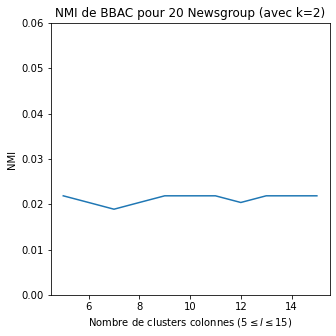

In [262]:
abs=np.arange(5,16,1)
plt.figure(figsize=(5, 5))
plt.title("NMI de BBAC pour 20 Newsgroup (avec k=2)")
plt.plot(abs,NMI_euc_vec) 
plt.ylim((0,0.06))
plt.xlabel("Nombre de clusters colonnes ($5\leq l \leq 15)$") ; plt.ylabel("NMI") ;
plt.show()

Ces résultats sont en accord avec ceux de l'article BBAC$^{[1]}$ qui, pour la base CLASSIC3, obtenaient peu de fluctuation dans les valeurs de NMI obtenues malgré une variation dans le nombre de clusters colonne $l$. 

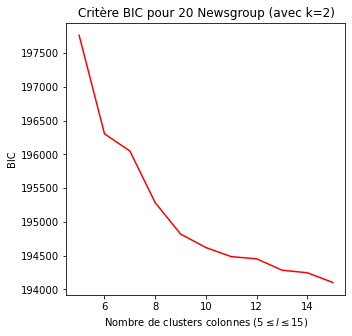

In [263]:
plt.figure(figsize=(5, 5))
plt.title("Critère BIC pour 20 Newsgroup (avec k=2)")
plt.plot(abs,BIC_euc_vec,c="red") 
plt.xlabel("Nombre de clusters colonnes ($5\leq l \leq 15)$") ; plt.ylabel("BIC") ;
plt.show()

Les résultats BIC orientent le choix du nombre optimal de clusters colonne, qui est ici donné par la valeur de l'argmin $l=15$. Cette valeur est donc censée traduire le meilleur compromis entre la maximisation de la logvraisemblance et la complexité du modèle parmi les valeurs $l \in\{5,...,15\}$. Il semble donc que pour ces valeurs de $l$, la pénalisation croissante en fonction du nombre de paramètres ne suffise pas à contrebalancer les bénéfices obtenus sur la vraisemblance lorsque l'on augmente la valeur de $l$.

De plus, le fait que la courbe soit décroissante sur tout l'intervalle considéré suggère qu'il serait intéressant de calculer les résultats BIC pour des valeurs de $l$ plus grandes encore dans l'espoir de trouver un point d'inflexion de la courbe qui indiquerait un minimum, au moins local, du critère (et non pas un minimum au bord comme c'est le cas ici). Nos capacités de calcul étant limitées, nous avons dû nous limiter aux valeurs présentées ici, mais il serait souhaitable d'effectuer des calculs pour $l$ variant de 5 à 50 par exemple, comme l'ont fait les auteurs de l'article BBAC.

Puisque la valeur du critère BIC nous a désigné $l=15$ comme nombre de clusters optimal, nous avons extrait les résultats de $\rho$ et $\gamma$ pour cette valeur de $l$ afin de faire quelques commentaires de conclusion. De par le graphique de NMI, il est clair que faire le choix de $l=15$ ne permettra pas d'obtenir des niveaux bien meilleurs sur cette métrique. Observons donc plutôt la matrice de confusion obtenue. 

In [280]:
# Résultats obtenus pour l=15
rho_l_15=np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])
gamma_l_15=np.array([2.0,9.0,8.0,8.0,8.0,14.0,8.0,8.0,8.0,4.0,8.0,8.0,12.0,12.0,13.0,8.0,12.0,13.0,12.0,8.0,5.0,5.0,5.0,11.0,12.0,12.0,5.0,12.0,12.0,1.0,5.0,12.0,12.0,12.0,1.0,13.0,12.0,12.0,12.0,0.0,12.0,12.0,12.0,12.0,12.0,0.0,0.0,0.0,12.0,12.0,12.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,12.0,6.0,0.0,1.0,12.0,12.0,12.0,10.0,5.0,12.0,12.0,11.0,12.0,6.0,11.0,12.0,6.0,12.0,12.0,3.0,7.0,0.0,3.0,12.0,12.0,12.0,12.0,12.0,3.0,12.0,12.0,7.0,11.0,1.0,3.0,3.0,0.0,7.0,0.0,1.0,3.0,10.0,12.0,3.0,11.0,12.0,6.0,0.0,12.0,0.0,12.0,11.0,12.0,10.0,10.0,6.0,7.0,12.0,0.0,0.0,11.0,7.0,1.0,11.0,6.0,10.0,7.0,7.0,3.0,12.0,7.0,10.0,7.0,10.0,7.0,3.0,3.0,10.0,6.0,12.0,7.0,10.0,11.0,7.0,7.0,10.0,11.0,12.0,1.0,7.0,12.0,7.0,7.0,6.0,7.0,11.0,10.0,7.0,10.0,7.0,10.0,7.0,10.0,10.0,12.0,6.0,7.0,7.0,11.0,11.0,11.0,7.0,10.0,12.0,10.0,11.0,10.0,7.0,11.0,10.0,7.0,6.0,7.0,6.0,7.0,7.0,10.0,3.0,10.0,7.0,7.0,7.0,7.0,7.0,10.0,7.0,10.0,10.0,11.0,10.0,7.0,1.0,10.0,7.0,7.0,10.0,6.0,10.0,10.0,10.0,6.0,10.0,11.0,0.0,10.0,7.0,6.0,6.0,10.0,7.0,1.0,6.0,3.0,7.0,7.0,7.0,10.0,3.0,6.0,7.0,7.0,7.0,6.0,7.0,7.0,10.0,7.0,10.0,11.0,10.0,6.0,6.0,6.0,7.0,6.0,10.0,7.0,10.0,10.0,7.0,10.0,7.0,7.0,7.0,7.0,7.0,7.0,3.0,7.0,7.0,7.0,7.0,7.0,10.0,3.0,10.0,10.0,7.0,7.0,7.0,6.0,10.0,3.0,7.0,6.0,7.0,6.0,7.0,7.0,10.0,6.0,11.0,7.0,10.0,11.0,6.0,7.0,7.0,10.0,7.0,6.0,6.0,6.0,10.0,3.0,7.0,6.0,7.0,10.0,7.0,7.0,3.0,7.0,7.0,10.0,7.0,10.0,7.0,7.0,6.0,10.0,6.0,7.0,6.0,10.0,10.0,3.0,7.0,3.0,7.0,7.0,3.0,7.0,7.0,7.0,10.0,7.0,10.0,10.0,7.0,7.0,3.0,6.0,11.0,10.0,7.0,10.0,10.0,10.0,10.0,7.0,7.0,10.0,7.0,7.0,7.0,10.0,10.0,10.0,10.0,10.0,6.0,3.0,10.0,7.0,7.0,7.0,7.0,7.0,10.0,3.0,7.0,7.0,6.0,10.0,7.0,6.0,6.0,7.0,7.0,7.0,11.0,7.0,7.0,6.0,7.0,6.0,3.0,10.0,7.0,7.0,3.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,10.0,7.0,3.0,7.0,3.0,7.0,10.0,10.0,7.0,7.0,7.0,7.0,6.0,7.0,10.0,10.0,7.0,7.0,7.0,7.0,7.0,10.0,7.0,6.0,7.0,10.0,7.0,6.0,6.0,7.0,3.0,10.0,7.0,7.0,7.0,7.0,10.0,7.0,7.0,3.0,7.0,7.0,10.0,7.0,6.0,10.0,6.0,7.0,7.0,6.0,7.0,7.0,7.0,7.0,6.0,7.0,6.0,6.0,7.0,7.0,7.0,7.0,3.0,7.0,7.0,10.0,10.0,7.0,10.0,7.0,7.0,3.0,7.0,10.0,6.0,7.0,7.0,7.0,6.0,10.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,10.0,7.0,7.0,10.0,10.0,7.0,7.0,6.0,7.0,7.0,7.0,10.0,7.0,7.0,3.0,10.0,7.0,7.0,7.0,10.0,10.0,6.0,6.0,7.0,10.0,7.0,10.0,7.0,6.0,7.0,7.0,10.0,7.0,7.0,7.0,7.0,7.0,10.0,10.0,6.0,10.0,7.0,7.0,3.0,7.0,7.0,7.0,10.0,7.0,3.0,6.0,7.0,7.0,7.0,7.0,3.0,7.0,7.0,10.0,10.0,7.0,7.0,7.0,10.0,7.0,6.0,7.0,10.0,7.0,10.0,10.0,7.0,10.0,7.0,10.0,7.0,7.0,7.0,7.0,3.0,7.0,7.0,10.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,10.0,7.0,7.0,10.0,10.0,7.0,10.0,7.0,10.0,7.0,10.0,7.0,7.0,7.0,6.0,7.0,10.0,7.0,7.0,10.0,10.0,6.0,10.0,7.0,10.0,6.0,7.0,10.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,10.0,10.0,10.0,7.0,10.0,7.0,6.0,7.0,3.0,10.0,7.0,7.0,7.0,10.0,10.0,10.0,7.0,7.0,10.0,3.0,7.0,7.0,7.0,6.0,7.0,7.0,7.0,6.0,10.0,7.0,7.0,7.0,10.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,6.0,7.0,7.0,10.0,7.0,7.0,10.0,7.0,7.0,7.0,7.0,7.0,6.0,6.0,7.0,10.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,10.0,7.0,7.0,10.0,10.0,10.0,7.0,7.0,7.0,10.0,7.0,6.0,6.0,7.0,6.0,10.0,10.0,7.0,7.0,7.0,10.0,7.0,7.0,7.0,7.0,7.0,10.0,10.0,7.0,10.0,10.0,7.0,6.0])

In [288]:
print("Matrice de confusion pour l=15 (et la distance euclidienne)")
Confusion_l_15=contingency_matrix(newsgroups_train.target, rho_l_15)
print(Confusion_l_15)

Matrice de confusion pour l=15 (et la distance euclidienne)
[[ 14 579]
 [  0 599]]


Nous reconnaissons la matrice de confusion que nous avions déjà obtenue pour BBAC avec $l=5$ et la distance euclidienne mais aussi lors de nos calculs "étalon" pour un simple K-means. De nouveau, il semble que la minimisation de la fonction objectif n'ait pas d'impact sur la qualité du partitionnement en ligne de la matrice. En effet, bien que nous ayons choisi le modèle qui minimise le critère BIC, l'impact ne se perçoit pas sur les valeurs de $\rho$. Notre fonction objectif ne semble pas destinée à la recherche de clusters ligne optimaux pour la matrice. 

Comme dernière démarche "étalon", calculons la valeur de la dite fonction objectif pour la vraie valeur de $\rho$ (le vecteur des labels réels, contenu dans notre variable **newsgroups_train.target**). Notons qu'il nous faut également une valeur pour $\gamma$ ce que les données d'origine ne possèdent pas. Nous utilisons donc la valeur **gamma_l_15**, optimale au sens du critère BIC, que nous avons obtenue pour un modèle ayant $l=15$ clusters colonnes. Afin d'avoir des résultats comparables à ceux de cette section, nous choisirons la version de la fonction objectif associée à la distance euclidienne.

In [290]:
# il nous faut définir MCC pour effectuer le calcul de fonction objectif
MCC=update_mcc(newsgroups_train.target,gamma_l_15,X_train,k=2,l=15,euclid=True)
# calcul de la fonction objectif 
obj_f=objective_function(newsgroups_train.target,gamma_l_15,MCC,X_train,k=2,l=15,euclid=True)
print("Valeur de la fonction objectif obtenue de manière artificielle sur les vrais labels mais sans apprentissage:\n",obj_f)
print("\nValeur finale de la fonction objectif obtenue pour l=15 avec div=euclid et initialisation par K-means:\n",Obj_list_euc_1[-1])

Valeur de la fonction objectif obtenue de manière artificielle sur les vrais labels mais sans apprentissage:
 0.2699820733829422

Valeur finale de la fonction objectif obtenue pour l=15 avec div=euclid et initialisation par K-means:
 0.23239047140802377


In [291]:
print("Vérifions que la matrice de confusion des vrais labels est bien diagonale : ")
print(contingency_matrix(newsgroups_train.target, newsgroups_train.target))

Vérifions que la matrice de confusion des vrais labels est bien diagonale : 
[[593   0]
 [  0 599]]


On constate donc qu'un vecteur $\rho$ ayant la meilleure matrice de confusion possible (parfaitement diagonale) a pourtant une valeur de fonction objectif plus élevée que certains de nos estimateurs. De nouveau, ce résultat semble montrer que la minimisation de la fonction objectif et le partitionnement idéal des lignes de la matrice ne coïncident pas.